# Initial model experiments

Imports and constants

In [1]:
import os
import pickle
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage import io
import cv2

import tensorflow as tf
from tensorflow.keras import Model, layers

Mounted at /content/drive/


In [2]:
# paths
DATA_IMAGES_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'interim')
PROCESSED_DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 
                                   'data', 'processed', 'data_11_classes_200.npy')
PROCESSED_LABELS_PATH = os.path.join(os.path.dirname(os.getcwd()), 
                                     'data', 'processed', 'labels_11_classes_200.npy')
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()), 
                          'models', 'painting-classification-model')
MODEL_PLOT_PATH = os.path.join(os.path.dirname(os.getcwd()), 
                               'models', 'painting-classification-model-plot.png')

# image properties
RANDOM_SEED = 7
IMG_WIDTH = 200
IMG_HEIGHT = 200
NUM_CHANNELS = 1

# training parameters
LEARNING_RATE = 1E-4
DECAY = 1E-6
BATCH_SIZE = 50
EPOCHS = 30

Let's parse all the filepaths and store them in a list

In [ ]:
img_path_list = [os.path.join(DATA_IMAGES_PATH, name) for name in os.listdir(DATA_IMAGES_PATH)]

In [ ]:
print(img_path_list[-900])
io.imshow(img_path_list[-900])

The following function will read in our images, resize them to desirable format and prepare labels for each of the images.

In [ ]:
def prepare_img_data(path_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    X = []
    y = []
    for value in path_list:
        try:
            X.append(np.array(cv2.resize((cv2.imread(value, cv2.IMREAD_GRAYSCALE)), 
                                         (img_width, img_height))))
            y.append(str.split(value, os.path.sep)[-1]
                     .split('_')[1]
                     .upper()
                     .replace('.JPG', ''))
        except Exception as e:
            print(f"Corrupted image: {value}, skipping the image")
    return X, y

In [ ]:
data, labels = prepare_img_data(img_path_list)

Looks like some of the images were corrupted and we couldn't resize them. For now we'll leave it as-is, since we're experimenting with data size and number of distinct classes anyways.

Now, let's see what the image looks like

Since we'll focus on building a proper pipeline later on, we can save the data as numpy arrays (and load it when necessary).

In [3]:
# np.save(PROCESSED_DATA_PATH, data)
# np.save(PROCESSED_LABELS_PATH, labels)

X = np.load(PROCESSED_DATA_PATH)
y = np.load(PROCESSED_LABELS_PATH)

For argument's sake, let's see what's the distribution of our data (we know there should be an equal number of all the instances within a class). 

In [4]:
unique, count = np.unique(y, return_counts=True)
occurences = dict(zip(unique, count))
print(f"The number of occurences of each class in the dataset = \n{occurences}")

The number of occurences of each class in the dataset = 
{'ART NOUVEAU (MODERN)': 1100, 'BAROQUE': 1100, 'CUBISM': 1100, 'EXPRESSIONISM': 1100, 'IMPRESSIONISM': 1100, 'REALISM': 1100, 'ROMANTICISM': 1100, 'SURREALISM': 1100, 'SYMBOLISM': 1100, 'UKIYO-E': 1098}


Let's visualize some of the data we just processed.

In [5]:
def shuffle_data(image_data, label_data, random_seed):
    return np.random.RandomState(random_seed).permutation(image_data), np.random.RandomState(random_seed).permutation(label_data)

def display_rand_imgs(image_data, label_data, random_seed):
    images, labels = shuffle_data(image_data, label_data, random_seed)
    
    fig, axes = plt.subplots(3, 3, figsize = (15,15))
    plt.suptitle("Random images and their labels", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(0, len(label_data))
            image = images[index]
            label = labels[index]
            axis.imshow(image, cmap='Greys')
            axis.set_title(f"Class: {label}")
            axis.set_axis_off()

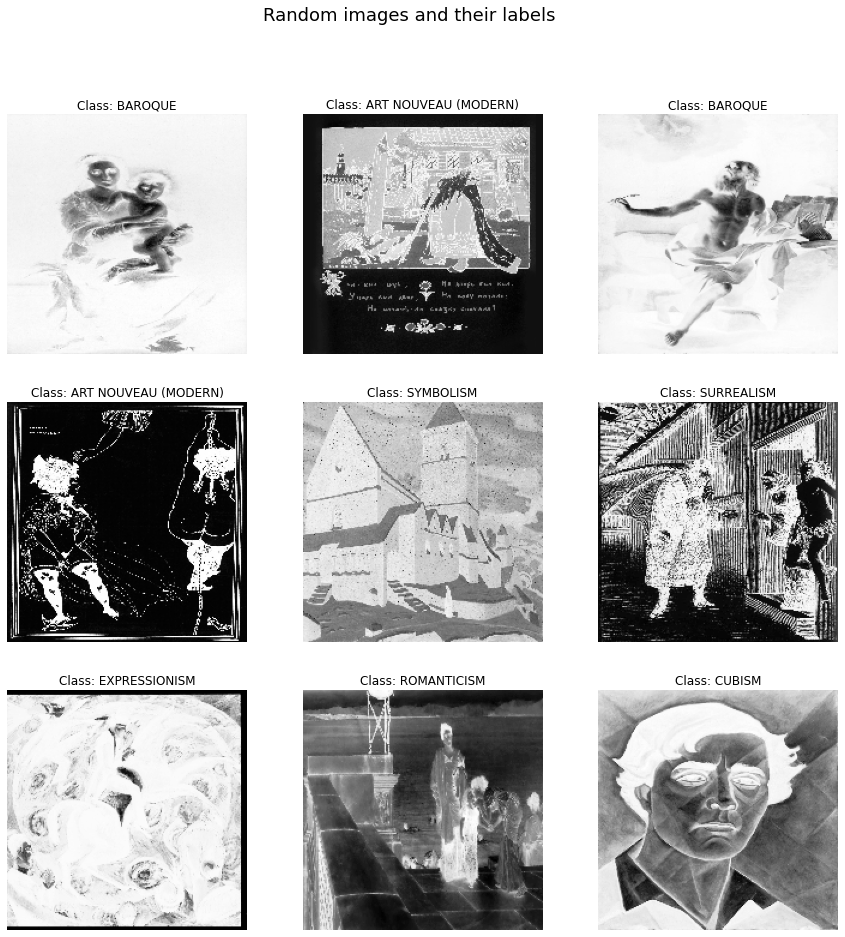

In [6]:
display_rand_imgs(X, y, RANDOM_SEED)

Lastly, we have to shuffle our data, reshape it to appropriate format for our input layer to handle it, transform labels and create train and test splits.

In [7]:
X, y = shuffle_data(X, y, RANDOM_SEED)

In [8]:
y[:10]

array(['BAROQUE', 'UKIYO-E', 'SYMBOLISM', 'CUBISM', 'EXPRESSIONISM',
       'IMPRESSIONISM', 'ART NOUVEAU (MODERN)', 'UKIYO-E', 'UKIYO-E',
       'ROMANTICISM'], dtype='<U20')

In [9]:
X = X.reshape(-1, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS).astype('float32')
X = X / 255.

In [10]:
le = LabelEncoder()
y = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y, len(unique))

print(f"Label value for 1st(0th) element before one-hot encoding \n {np.argmax(y[0])} \nand after one-hot encoding \n {y[0]}")

Label value for 1st(0th) element before one-hot encoding 
 1 
and after one-hot encoding 
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


We'll also set the `NUM_CLASSES` constant to a parameter calculated above 

In [11]:
NUM_CLASSES = y.shape[1]

In [12]:
X.shape, y.shape

((10998, 200, 200, 1), (10998, 10))

And split the data

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8798, 200, 200, 1), (2200, 200, 200, 1), (8798, 10), (2200, 10))

Time to build our model. Since we'll be changing the way our project works and is structured completely within the next few commits, it doesn't really matter how we choose to build it during this experiment. 

After lots of trial nad error, we decided on a CNN with skip connections which we built with Functional API. 

In [40]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), name="img")

x = layers.Conv2D(64, 5, activation="relu")(inputs)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(128, 5, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(128, 5, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(128, 5, activation="relu", padding="same")(x)
block_2_output = layers.concatenate([x, block_1_output])

x = layers.Conv2D(128, 5, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(128, 5, activation="relu", padding="same")(x)
block_3_output = layers.concatenate([x, block_2_output])

x = layers.Conv2D(256, 5, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name="paintings_resnet")

Let's choose optimizers, the loss that will be calculated each step and finally, compile the model

In [41]:
opt_func = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


model.compile(loss='categorical_crossentropy', optimizer=opt_func, metrics=['accuracy'])

Let's train the model above

In [42]:
hist = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Epoch 1/30
141/141 [==============================] - 18s 128ms/step - loss: 2.2529 - accuracy: 0.1391 - val_loss: 2.1738 - val_accuracy: 0.1943
Epoch 2/30
141/141 [==============================] - 18s 131ms/step - loss: 2.1395 - accuracy: 0.2145 - val_loss: 2.1293 - val_accuracy: 0.2045
Epoch 3/30
141/141 [==============================] - 18s 127ms/step - loss: 2.0637 - accuracy: 0.2408 - val_loss: 2.0996 - val_accuracy: 0.2244
Epoch 4/30
141/141 [==============================] - 18s 124ms/step - loss: 1.9853 - accuracy: 0.2802 - val_loss: 2.0256 - val_accuracy: 0.2506
Epoch 5/30
141/141 [==============================] - 18s 124ms/step - loss: 1.9343 - accuracy: 0.2972 - val_loss: 1.9320 - val_accuracy: 0.3085
Epoch 6/30
141/141 [==============================] - 18s 126ms/step - loss: 1.8856 - accuracy: 0.3286 - val_loss: 1.8757 - val_accuracy: 0.3364
Epoch 7/30
141/141 [==============================] - 18s 127ms/step - loss: 1.8569 - accuracy: 0.3342 - val_loss: 1.8308 - val_ac

Let's see what our model looks like and the number of it's parameters

In [17]:
print(model.summary())

Model: "paintings_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 196, 196, 64) 1664        img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 65, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 61, 61, 128)  204928      max_pooling2d[0][0]              
___________________________________________________________________________________

Let's see what our model looks like

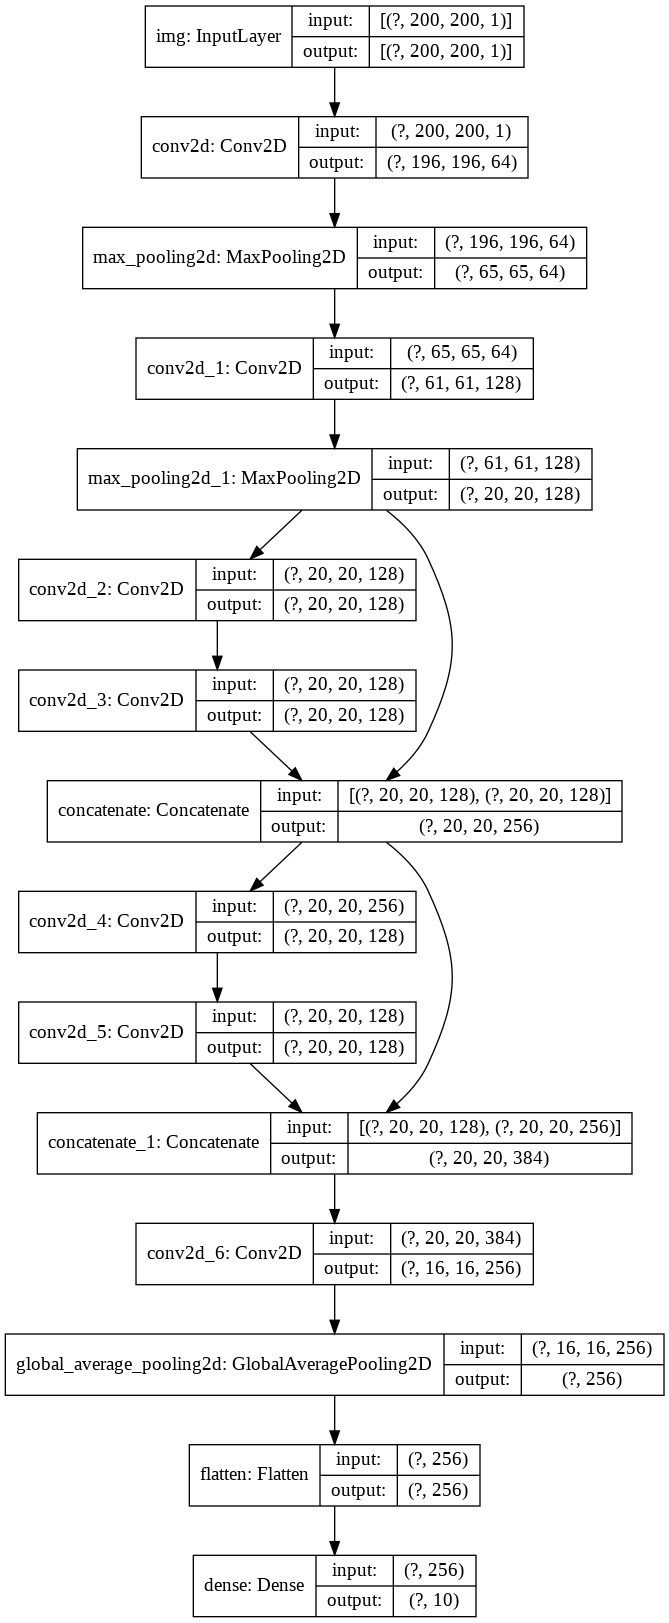

In [18]:
tf.keras.utils.plot_model(model, to_file=MODEL_PLOT_PATH, show_shapes=True)

Let's visualise the model's performance

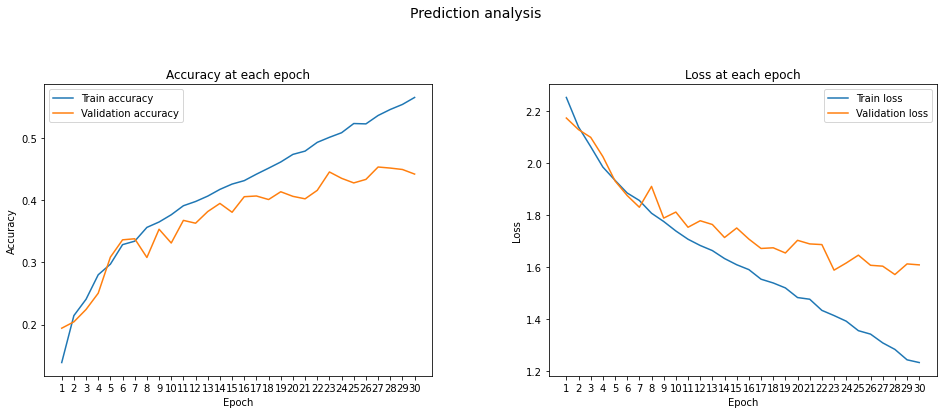

In [43]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
title = figure.suptitle('Prediction analysis', fontsize=14)
figure.subplots_adjust(top=0.8, wspace=0.3)

epoch_list = list(range(1, EPOCHS+1))
# ax1.axhline(y=0.8, color="0.85")
ax1.plot(epoch_list, hist.history['accuracy'], label='Train accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation accuracy')
ax1.set_xticks(np.arange(1, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy at each epoch')
l1 = ax1.legend(loc="best")

# ax2.axhline(y=0.1, color="0.85")
ax2.plot(epoch_list, hist.history['loss'], label='Train loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(1, EPOCHS+1, 1))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss at each epoch')
l2 = ax2.legend(loc="best")

Let's check the model's performance on a never seen before test set

In [44]:
val_loss, val_acc = model.evaluate(x_test, y_test)
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test set loss: {score[0]}')
print(f'Test set accuracy: {score[1]}')

69/69 [==============================] - 2s 26ms/step - loss: 1.5512 - accuracy: 0.4791
Test set loss: 1.5512362718582153
Test set accuracy: 0.4790908992290497


Plotting a confusion matrix should help us understand where the model struggled and where it performed well

Text(0.5, 60.0, 'Predicted labels')

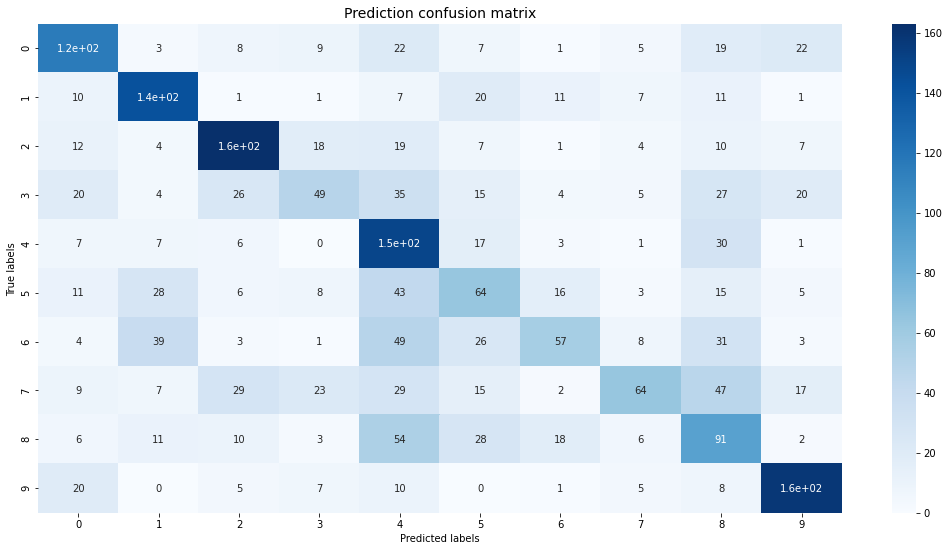

In [45]:
prediction = model.predict(x_test)
predicted_labels = np.argmax(prediction, axis=1)
test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(18, 9))
ax = sns.heatmap(cm,annot=True, cmap='Blues')

plt.title("Prediction confusion matrix", fontsize=14)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [46]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.54      0.55      0.54       212
           1       0.58      0.67      0.62       211
           2       0.63      0.67      0.65       245
           3       0.41      0.24      0.30       205
           4       0.36      0.68      0.47       222
           5       0.32      0.32      0.32       199
           6       0.50      0.26      0.34       221
           7       0.59      0.26      0.37       242
           8       0.31      0.40      0.35       229
           9       0.67      0.74      0.70       214

    accuracy                           0.48      2200
   macro avg       0.49      0.48      0.47      2200
weighted avg       0.50      0.48      0.47      2200



In [47]:
correct = []
incorrect = []

for i in range(len(y_test)):
    if(predicted_labels[i] == test_labels[i]):
        correct.append(i)
    elif(predicted_labels[i] != test_labels[i]):
        incorrect.append(i)
        
print(f"Our model predicted {len(correct)} out of {len(y_test)} images correctly, while {len(incorrect)} predictions were incorrect")

Our model predicted 1054 out of 2200 images correctly, while 1146 predictions were incorrect


In [48]:
def plot_predictions(pred_list, pred_string):
    fig, axes = plt.subplots(2, 5, figsize = (16,8))
    plt.suptitle(f"{pred_string} predictions", fontsize=18)
    index = 0
    for row in axes:
        for axis in row:
            index += 1
            axis.imshow(x_test[pred_list[index]].reshape(IMG_HEIGHT,IMG_WIDTH), cmap='binary')
            axis.set_title(f"Predicted Label : {predicted_labels[pred_list[index]]} \n Actual Label : {test_labels[pred_list[index]]}")
            axis.set_axis_off()

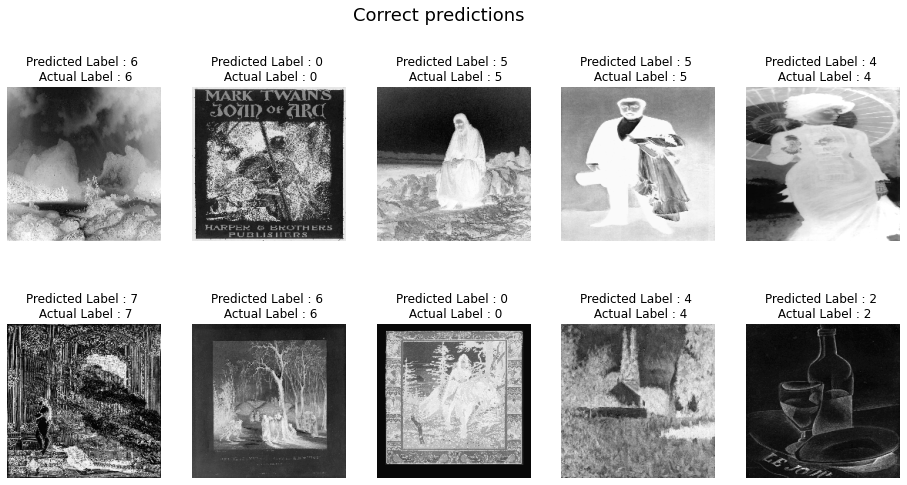

In [49]:
plot_predictions(correct, "Correct")

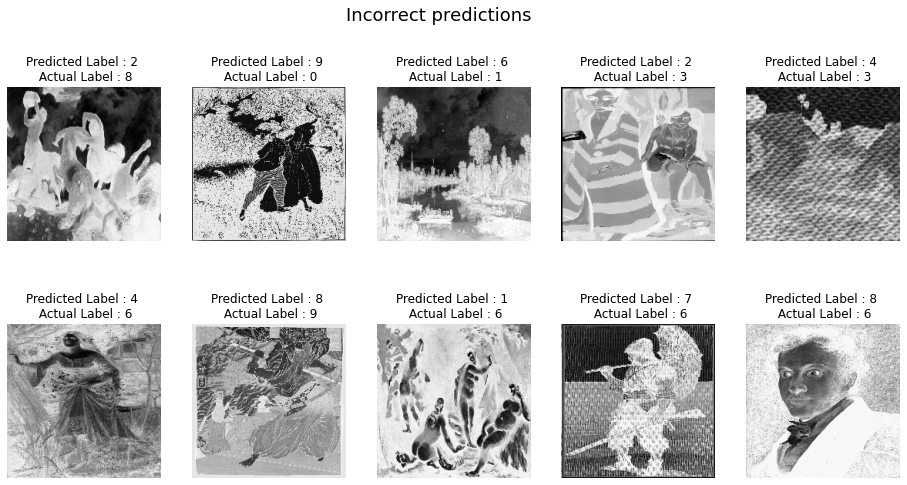

In [50]:
plot_predictions(incorrect, "Incorrect")

In [51]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: /content/drive/My Drive/painting-style/data/saved-model/assets
